In [1]:
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Params
DATA_FOLDER = os.path.join(os.path.abspath(''), '../../data')
RESULTS_FOLDER = os.path.join(os.path.abspath(''), '../results')

# Style
sns.set_theme(context='talk', style='white', palette='Accent')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'Helvetica'  # NOTE: Make sure to download Helvetica

# Conversion
inhibitory_ct = np.array(['Lamp5', 'Pvalb', 'Sncg', 'Sst', 'Lamp5.Lhx6', 'Vip', 'Pax6', 'Chandelier'])  # 'Sst.Chodl'
excitatory_ct = np.array(['L2.3.IT', 'L4.IT', 'L5.IT', 'L5.ET', 'L5.6.NP', 'L6b', 'L6.IT', 'L6.CT', 'L6.IT.Car3'])
major_ct = np.array(['astro', 'endo', 'excitatory', 'inhibitory', 'micro', 'oligo', 'opc', 'vlmc'])
minor_ct = np.array(list(inhibitory_ct) + list(excitatory_ct))
merged_ct = np.array(list(major_ct) + list(minor_ct))
conversion_ct = {**{ct: 'inhibitory' for ct in inhibitory_ct}, **{ct: 'excitatory' for ct in excitatory_ct}, **{ct: ct for ct in major_ct}}

# Determine and Plot Cutoffs

/tmp/ipykernel_586/1490837996.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(5, 3))


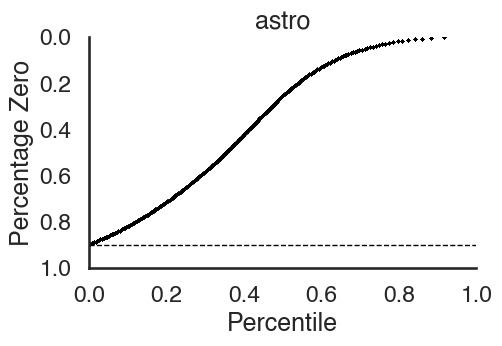

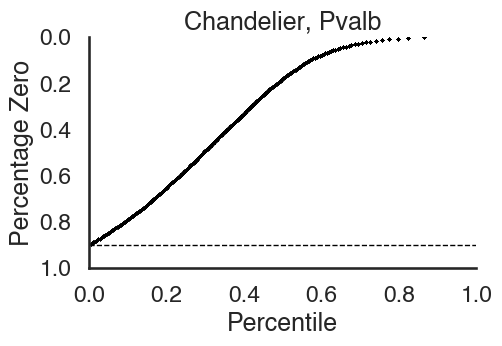

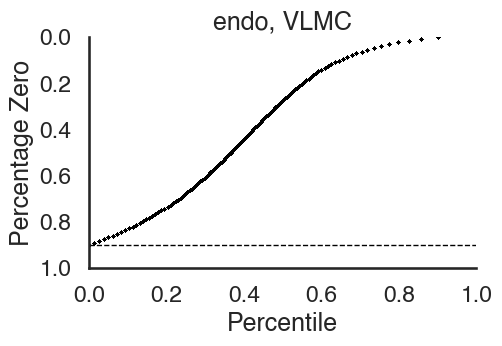

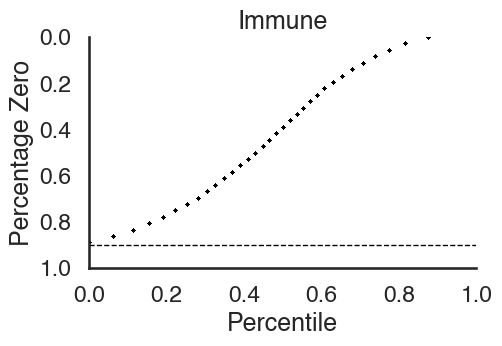

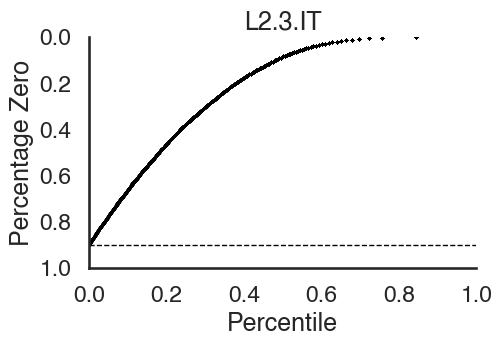

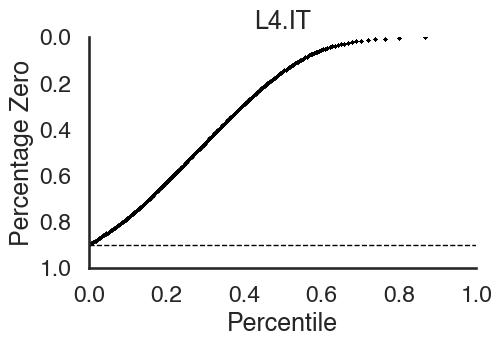

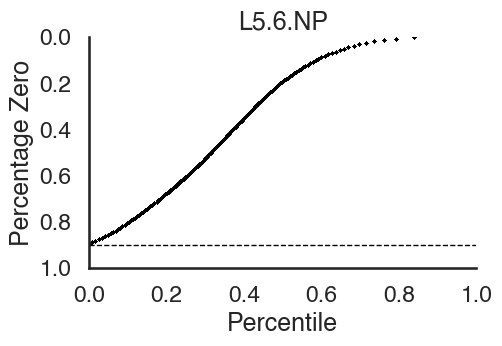

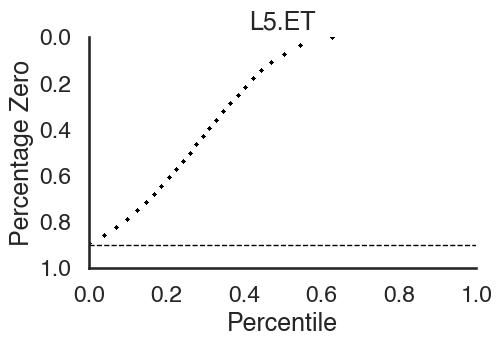

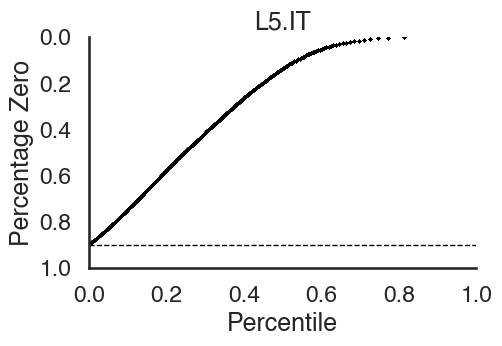

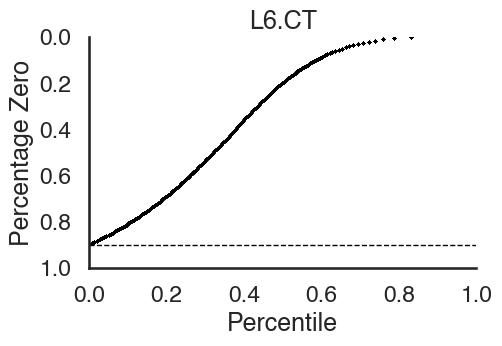

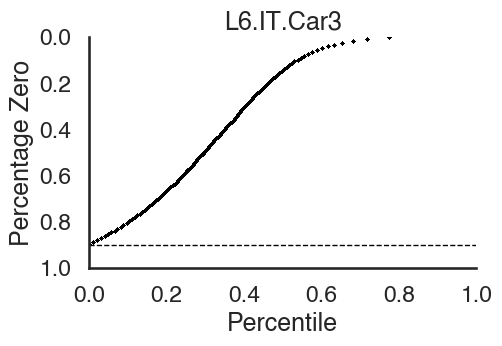

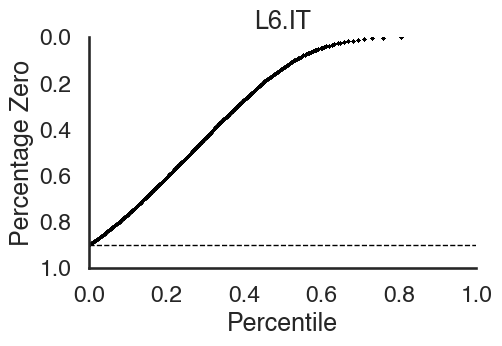

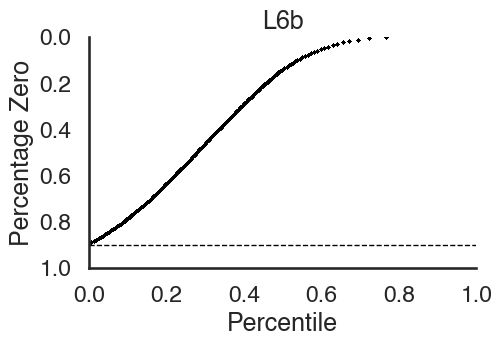

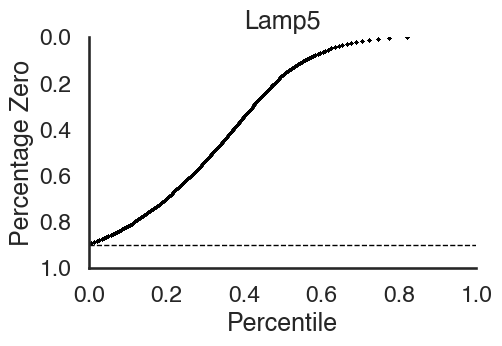

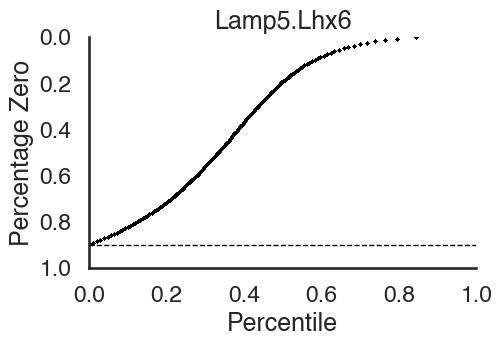

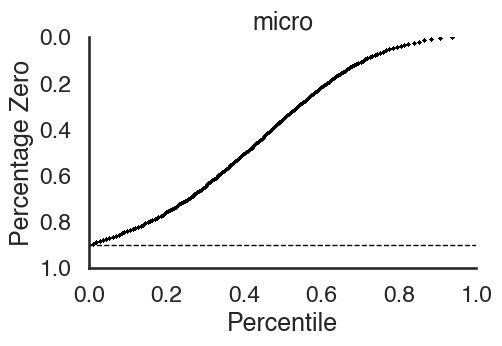

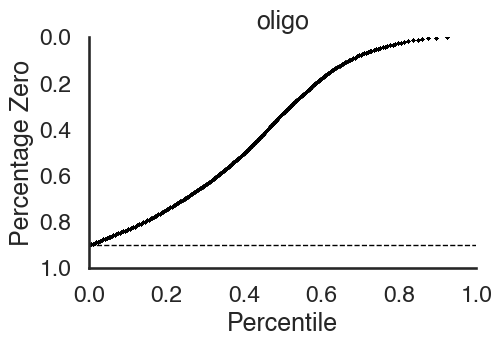

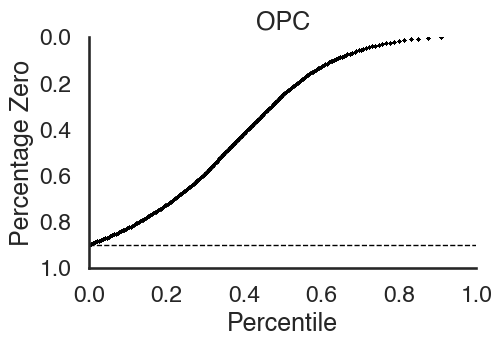

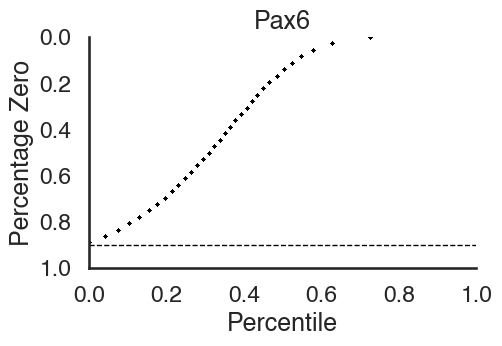

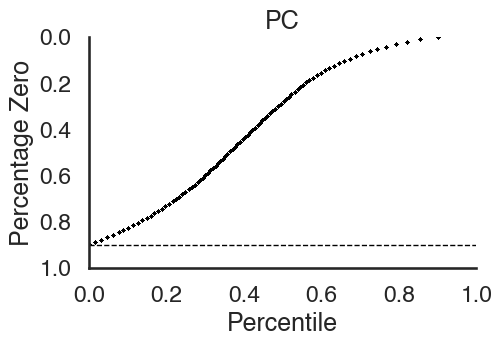

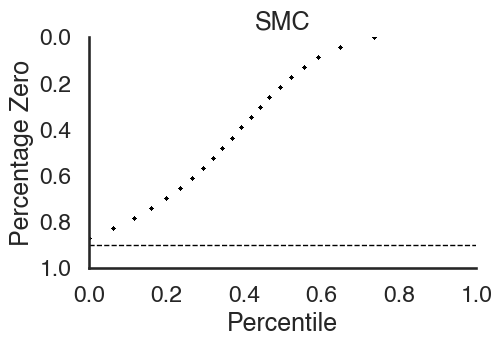

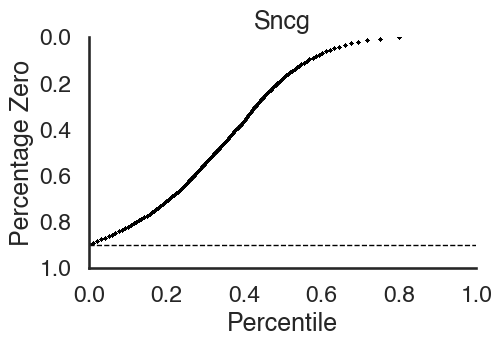

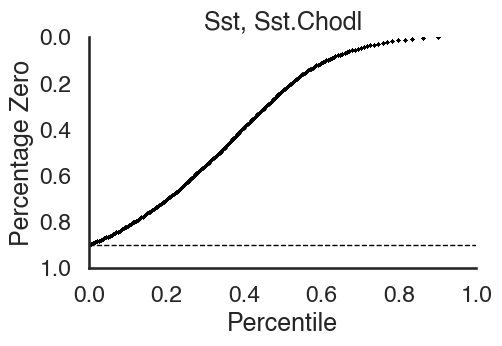

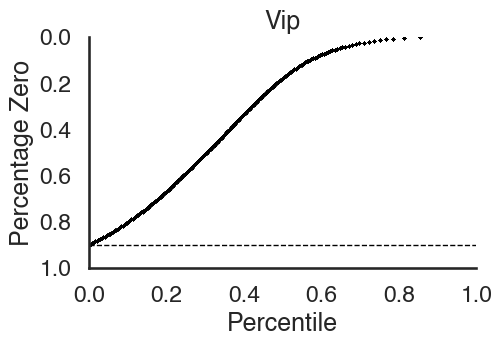

In [2]:
# Params
pct_zero_cutoff = .9  # Already done in bulk data
EXP_FOLDER = os.path.join(DATA_FOLDER, 'pseudobulk_expr')

ct_formatting = {**{'Micro.PVM': 'micro'}, **{v.capitalize(): v for v in major_ct}}
for fname in os.listdir(EXP_FOLDER):
    # Read data
    cell_types = '.'.join(fname.split('.')[:-2]).split('__')
    for i in range(len(cell_types)):
        if cell_types[i] in ct_formatting: cell_types[i] = ct_formatting[cell_types[i]]
    info_cols = ['#chr', 'start', 'end', 'length', 'strand']  # 'gene'
    expression = pd.read_csv(os.path.join(EXP_FOLDER, fname), delimiter='\t')
    expression = expression.set_index('gene').drop(columns=info_cols)  # .applymap(lambda x: 10**x - 1)

    # Plot cutoff
    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    zero_pct = (expression == 0).mean(axis=1).reset_index(name='Percentage Zero')
    zero_pct['Percentile'] = zero_pct.apply(lambda r: (r['Percentage Zero'] < zero_pct['Percentage Zero']).mean(), axis=1)
    sns.scatterplot(data=zero_pct, x='Percentile', y='Percentage Zero', color='black', s=5, linewidth=0)
    sns.despine()
    ax.axhline(y=pct_zero_cutoff, color='black', lw=1, ls='--')
    ax.set_title(', '.join(cell_types))
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.invert_yaxis()

    # Save cutoff
    valid_genes = zero_pct.loc[zero_pct['Percentage Zero'] <= pct_zero_cutoff, 'gene'].to_numpy()
    for ct in cell_types: np.savetxt(os.path.join(RESULTS_FOLDER, f'{ct}_valid_genes.txt'), valid_genes, fmt='%s')

# Gene Lookup

In [3]:
# Load data
fname_ct = 'Micro.PVM'
expression = pd.read_csv(os.path.join(EXP_FOLDER, f'{fname_ct}.expr.bed'), delimiter='\t')
expression = expression.set_index('gene').drop(columns=info_cols)
zero_pct = (expression == 0).mean(axis=1).reset_index(name='Percentage Zero')
zero_pct['Percentile'] = zero_pct.apply(lambda r: (r['Percentage Zero'] < zero_pct['Percentage Zero']).mean(), axis=1)

# Search for gene
start = 'CNK'
print(f'Genes like "{start}...":')
print(', '.join([gene for gene in expression.index if gene.startswith('CNK')]))
print()

# Test gene
genes = ['ZNF385B', 'GRIK2', 'RAPGEF4']
for gene in genes:
    print(gene)
    gene_mean_exp = expression.loc[gene].mean()
    print(f'Mean Log Expression: {gene_mean_exp:.3f}')
    _, gene_zero_pct, gene_percentile = zero_pct.loc[zero_pct['gene'] == gene].to_numpy()[0]
    print(f'Zero Percentage: {gene_zero_pct:.3f} (Percentile {100*gene_percentile:.1f})')
    print()

Genes like "CNK...":
CNKSR1, CNKSR3

ZNF385B
Mean Log Expression: 2.856
Zero Percentage: 0.309 (Percentile 53.2)

GRIK2
Mean Log Expression: 3.496
Zero Percentage: 0.285 (Percentile 54.9)

RAPGEF4
Mean Log Expression: 3.853
Zero Percentage: 0.155 (Percentile 65.2)

